
### Assignment #7: 

1. Train for 20 epochs
2. Get 10 misclassified images
3. Get 10 GradCam outputs on any misclassified images (remember that you MUST use the library we discussed in the class)
4. Apply these transforms while training:
    RandomCrop(32, padding=4)
    CutOut(16x16)


In [118]:
!git clone https://github.com/TSAI-EVA8/StarterKit.git

Cloning into 'StarterKit'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 2), reused 24 (delta 2), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [1]:
import os
import sys
import torch
from pathlib import Path
#from data.dataset import CIFAR10
import torchvision
from torchsummary import summary
import torchvision.transforms as transforms
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import random


# parentPath=os.path.abspath('../../EVA8')
# sys.path.append(parentPath)
# print(parentPath)

## import the functtions from the common repo

In [2]:
from StarterKit.models.resnet18 import ResNet18 as md  ##in this case md()
##import StarterKit.models.resnet18 as md .. in this case md.ResNet18()
import StarterKit.utils as utility
import StarterKit.main as main
import StarterKit.gradcam as gradcamUtility
import StarterKit.transforms as myTransform

## Configurations 

In [3]:
class Args:


    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    vertical_flip_prob = 0.0
    gaussian_blur_prob = 0.0
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 20
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 25
    lr_gamma = 0.1

    # Evaluation
    # ==========
    sample_count = 25



In [4]:
## check for the GPU
isCuda, device = utility.initialize_cuda(112)

GPU Available? True


## Load the model

In [5]:
## get the model
model = md().to(device)  # Create model
summary(model, (3,32,32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Fetch the CIFAR data and apply the transforms

In [6]:
def getCIFAR10Data(transform_Train,transform_Test):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_Train)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=Args.train_batch_size,
                                              shuffle=True, num_workers=Args.num_workers)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_Test)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=Args.val_batch_size,
                                             shuffle=False, num_workers=Args.num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainLoader,testLoader,classes



In [7]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop(32,4),
     transforms.RandomRotation((-18.0, 18.0), fill=(1,)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train.transforms.append(myTransform.Cutout(n_holes=1, length=16))

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader,test_loader,classes=getCIFAR10Data(transform_train,transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Displaying Few Images

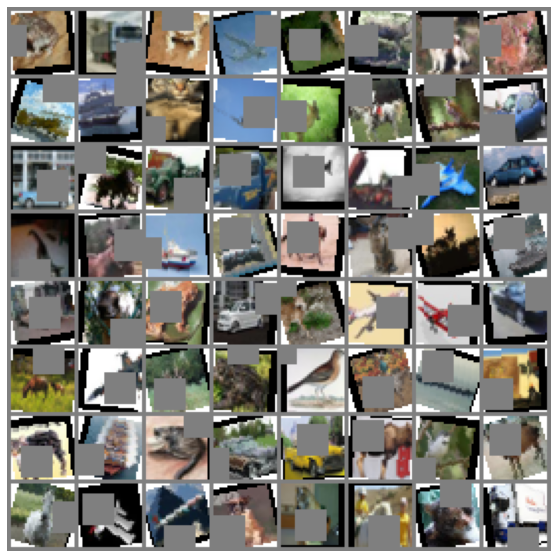

In [8]:
utility.displayImageGridFromLoader(train_loader)

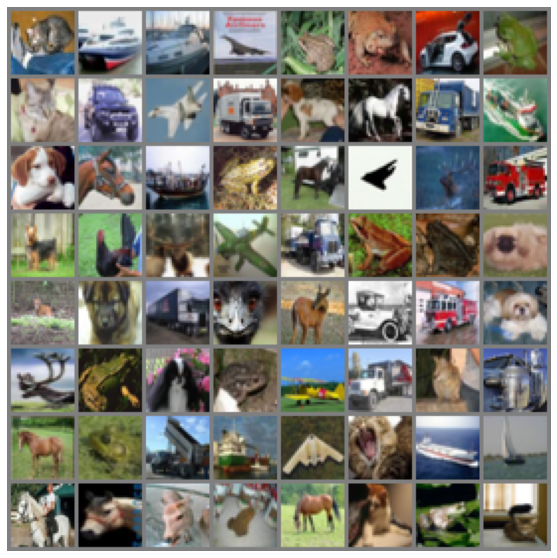

In [9]:
utility.displayImageGridFromLoader(test_loader)

## Training the Model

In [10]:
test_losses = []
test_accuracies = []
train_losses= []
train_accuracies=[]
correct_samples = []
incorrect_samples = []

criterion = main.cross_entropy_loss()  # Create loss function
optimizer = main.sgd_optimizer(model, Args.learning_rate, Args.momentum)  # Create optimizer
#scheduler = main.lr_scheduler(optimizer, Args.lr_step_size, Args.lr_gamma)
last_epoch = False

for epoch in range(1, Args.epochs+1):
    print(f'Epoch {epoch}:')
    if epoch == Args.epochs:
        last_epoch = True
    main.train(model, train_loader, device, optimizer,train_losses,train_accuracies, criterion)
    #scheduler.step()
    main.eval(
        model, test_loader, device, criterion, test_losses, test_accuracies,
        correct_samples, incorrect_samples, Args.sample_count, last_epoch=last_epoch
    )

Epoch 1:


Loss=1.97 Batch_ID=781 Train_Accuracy=38.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:35<00:00, 21.79it/s]


Test set: Average loss: 0.0224, Accuracy: 5027/10000 (50.27%)

Epoch 2:


Loss=1.60 Batch_ID=781 Train_Accuracy=51.88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:36<00:00, 21.36it/s]


Test set: Average loss: 0.0175, Accuracy: 6042/10000 (60.42%)

Epoch 3:


Loss=1.57 Batch_ID=781 Train_Accuracy=59.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.03it/s]


Test set: Average loss: 0.0148, Accuracy: 6629/10000 (66.29%)

Epoch 4:


Loss=1.46 Batch_ID=781 Train_Accuracy=63.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.01it/s]


Test set: Average loss: 0.0147, Accuracy: 6826/10000 (68.26%)

Epoch 5:


Loss=1.74 Batch_ID=781 Train_Accuracy=67.31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.95it/s]


Test set: Average loss: 0.0113, Accuracy: 7637/10000 (76.37%)

Epoch 6:


Loss=1.20 Batch_ID=781 Train_Accuracy=70.55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.99it/s]


Test set: Average loss: 0.0095, Accuracy: 7914/10000 (79.14%)

Epoch 7:


Loss=1.01 Batch_ID=781 Train_Accuracy=72.58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.99it/s]


Test set: Average loss: 0.0092, Accuracy: 8018/10000 (80.18%)

Epoch 8:


Loss=0.54 Batch_ID=781 Train_Accuracy=74.03: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.96it/s]


Test set: Average loss: 0.0094, Accuracy: 7986/10000 (79.86%)

Epoch 9:


Loss=0.89 Batch_ID=781 Train_Accuracy=75.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.93it/s]


Test set: Average loss: 0.0091, Accuracy: 8099/10000 (80.99%)

Epoch 10:


Loss=0.50 Batch_ID=781 Train_Accuracy=76.89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.93it/s]


Test set: Average loss: 0.0092, Accuracy: 8071/10000 (80.71%)

Epoch 11:


Loss=0.56 Batch_ID=781 Train_Accuracy=77.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.99it/s]


Test set: Average loss: 0.0077, Accuracy: 8424/10000 (84.24%)

Epoch 12:


Loss=0.34 Batch_ID=781 Train_Accuracy=79.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.94it/s]


Test set: Average loss: 0.0085, Accuracy: 8199/10000 (81.99%)

Epoch 13:


Loss=0.46 Batch_ID=781 Train_Accuracy=79.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.05it/s]


Test set: Average loss: 0.0074, Accuracy: 8436/10000 (84.36%)

Epoch 14:


Loss=0.15 Batch_ID=781 Train_Accuracy=80.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.99it/s]


Test set: Average loss: 0.0071, Accuracy: 8515/10000 (85.15%)

Epoch 15:


Loss=0.99 Batch_ID=781 Train_Accuracy=81.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.97it/s]


Test set: Average loss: 0.0067, Accuracy: 8553/10000 (85.53%)

Epoch 16:


Loss=0.30 Batch_ID=781 Train_Accuracy=81.98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.07it/s]


Test set: Average loss: 0.0067, Accuracy: 8617/10000 (86.17%)

Epoch 17:


Loss=0.24 Batch_ID=781 Train_Accuracy=82.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.00it/s]


Test set: Average loss: 0.0065, Accuracy: 8684/10000 (86.84%)

Epoch 18:


Loss=0.38 Batch_ID=781 Train_Accuracy=83.33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.99it/s]


Test set: Average loss: 0.0064, Accuracy: 8639/10000 (86.39%)

Epoch 19:


Loss=0.80 Batch_ID=781 Train_Accuracy=83.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.02it/s]


Test set: Average loss: 0.0058, Accuracy: 8814/10000 (88.14%)

Epoch 20:


Loss=0.72 Batch_ID=781 Train_Accuracy=84.39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 21.07it/s]


Test set: Average loss: 0.0062, Accuracy: 8730/10000 (87.30%)



## Check the plots 

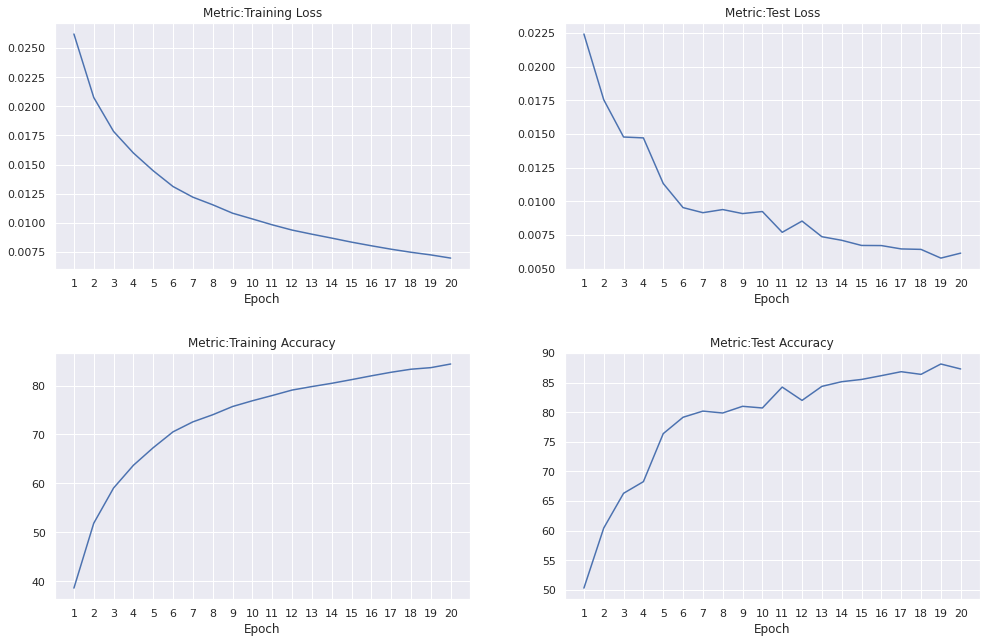

In [11]:
utility.plotLossAccuracyCurve(train_losses,train_accuracies,test_losses,test_accuracies)

## Draw gradCam images

/home/gauravp/anaconda3/envs/transformerlatest/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/gauravp/anaconda3/envs/transformerlatest/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


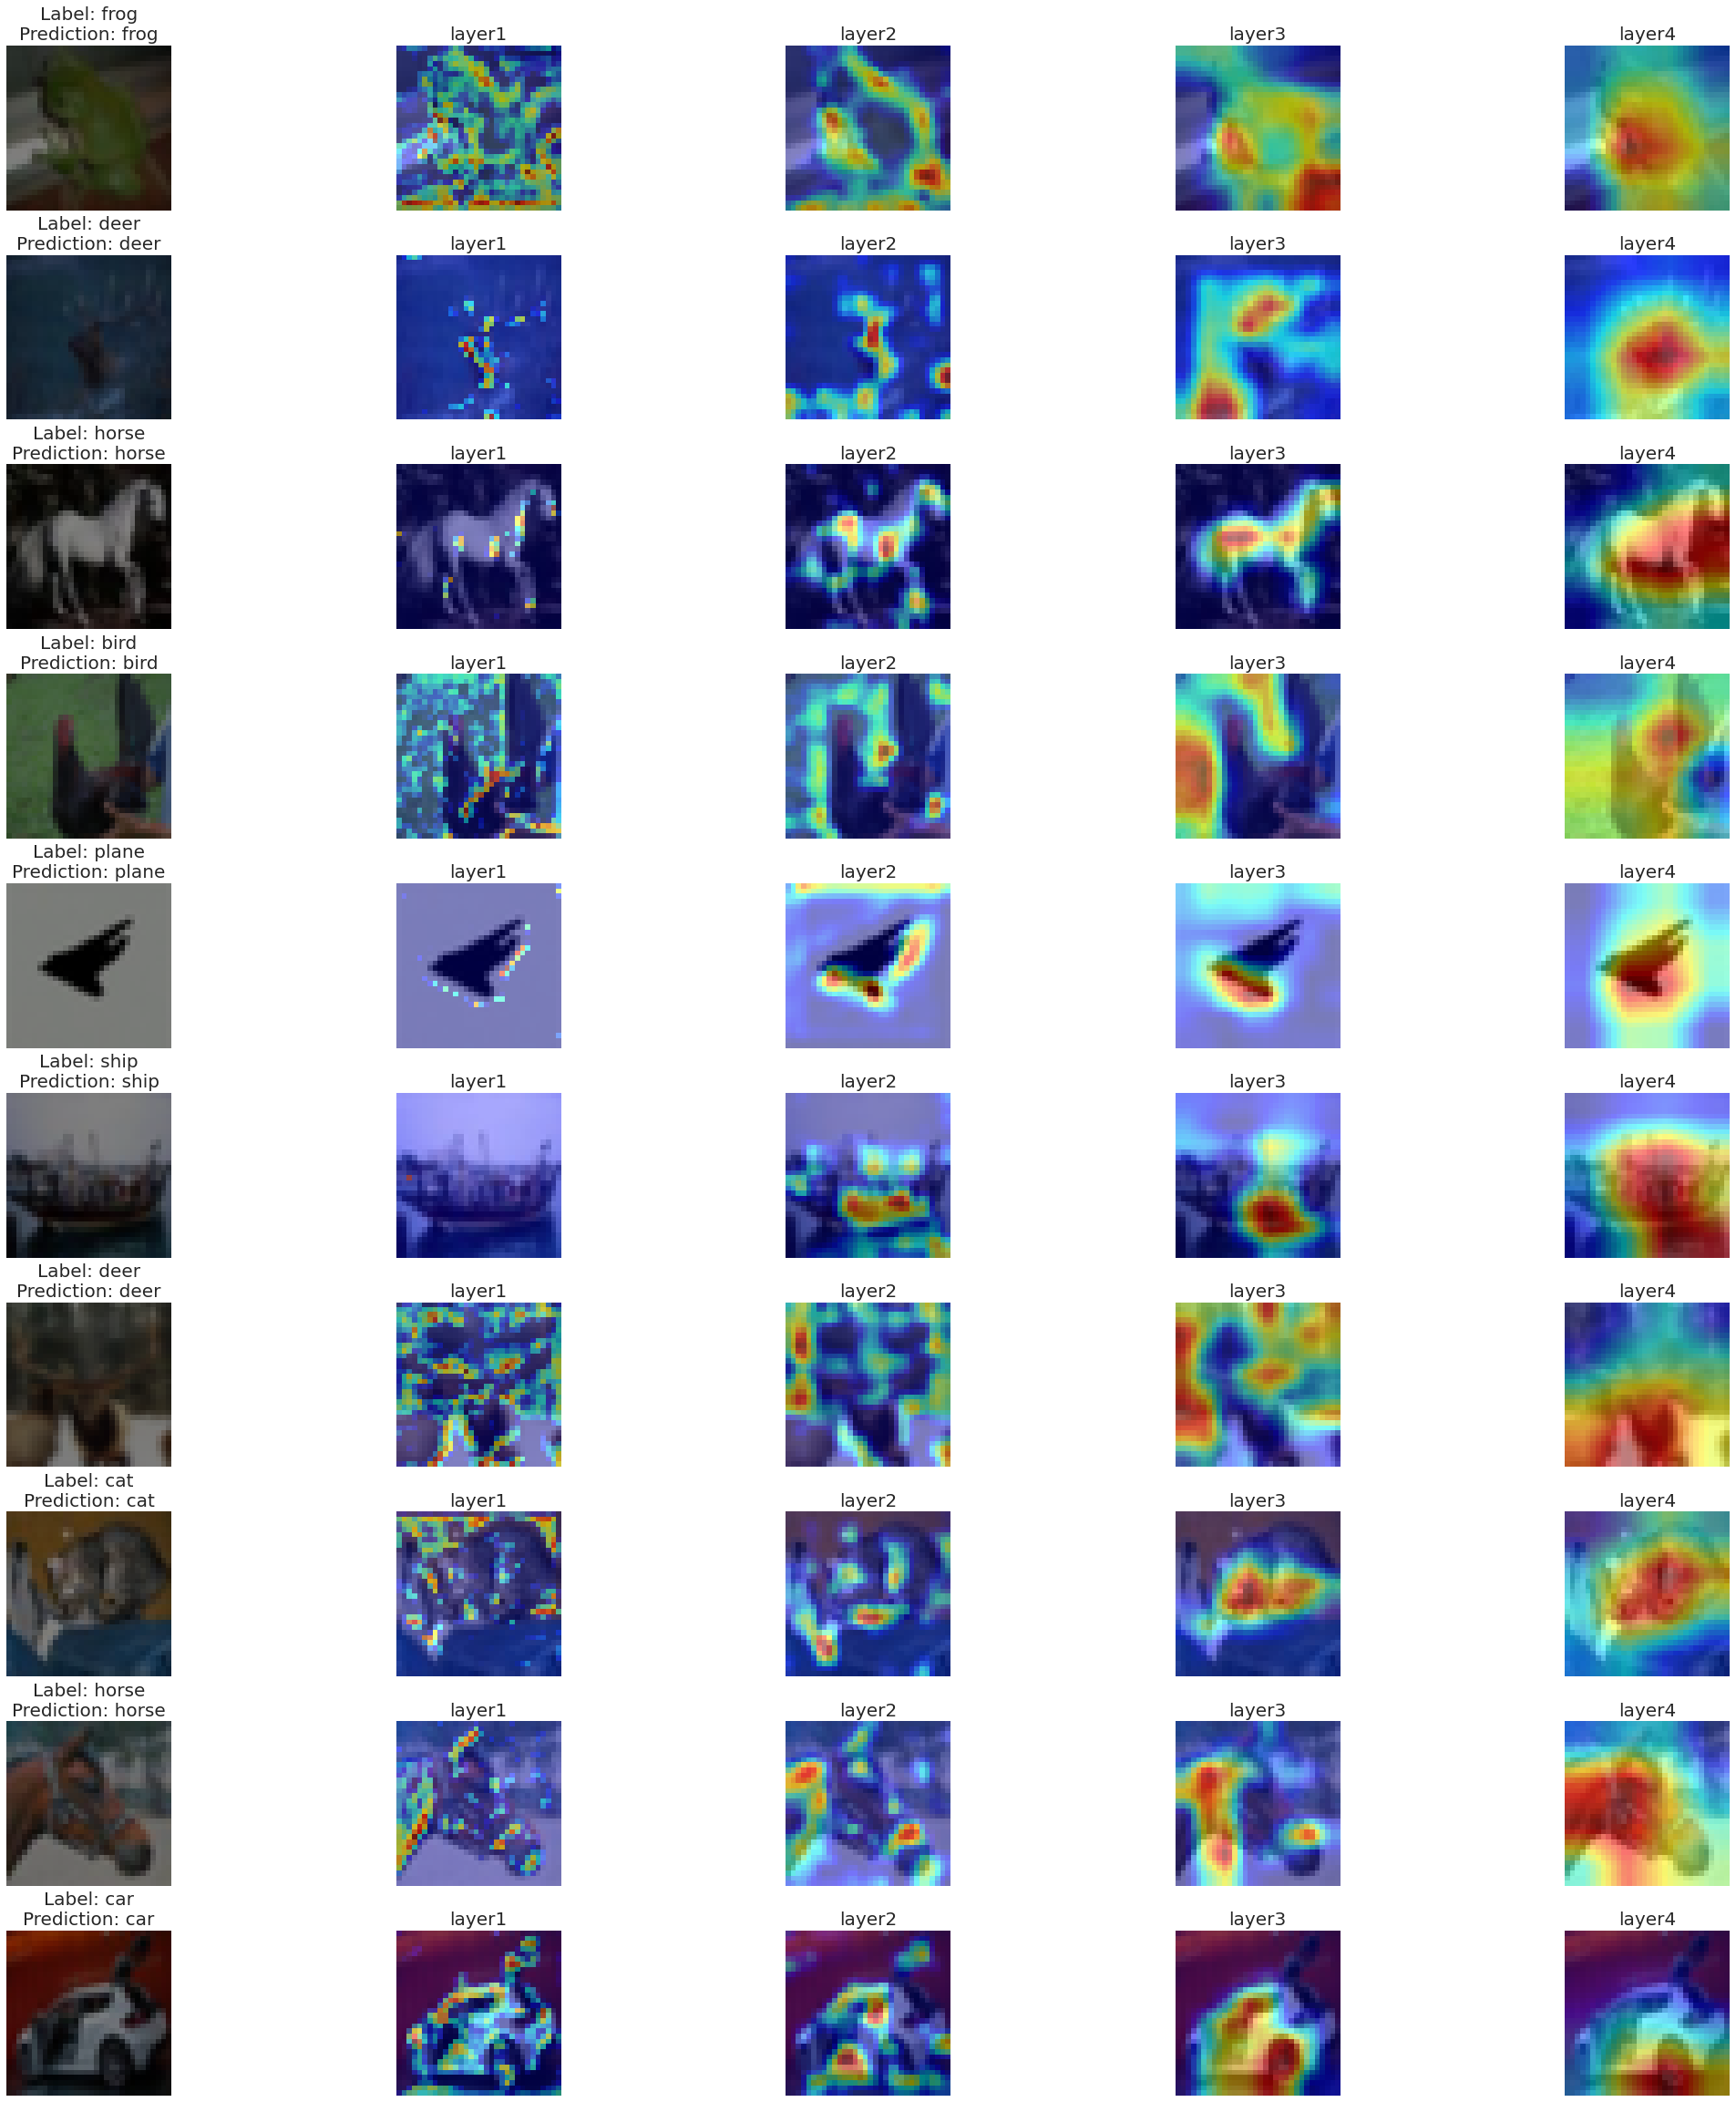

<Figure size 432x288 with 0 Axes>

In [12]:
grad_cam = gradcamUtility.GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, 0.5, 0.5
)

## fetch 10 random images .. we will add the class labels for printing purpose
imgData = [x for x in random.sample(correct_samples, 10)]
for idx in range(0,len(imgData)):
    imgData[idx]['labelClass']=classes[int(imgData[idx]['label'])]
    imgData[idx]['predictionClass']=classes[int(imgData[idx]['prediction'])]

grad_cam(imgData,'grad_cam')

## Displaying The correctly classificed images

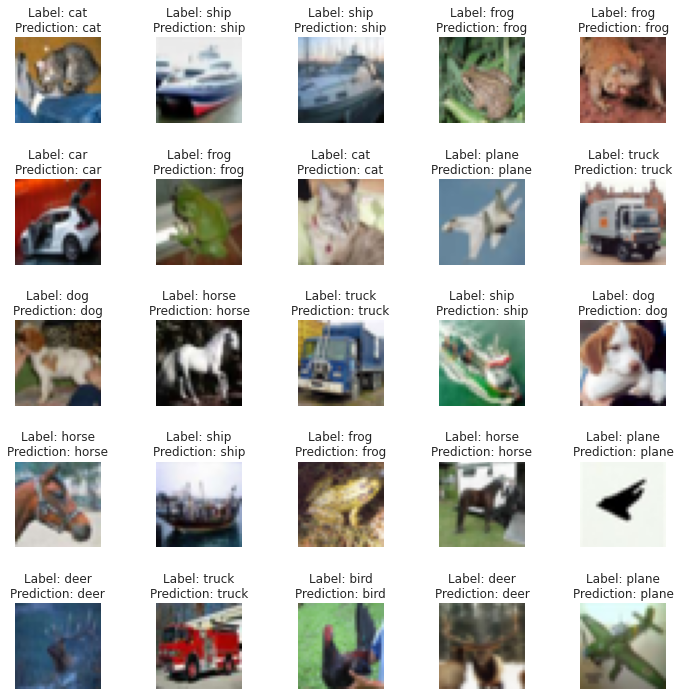

In [13]:
utility.save_and_show_result(correct_samples, classes)

## Displaying the misclassification

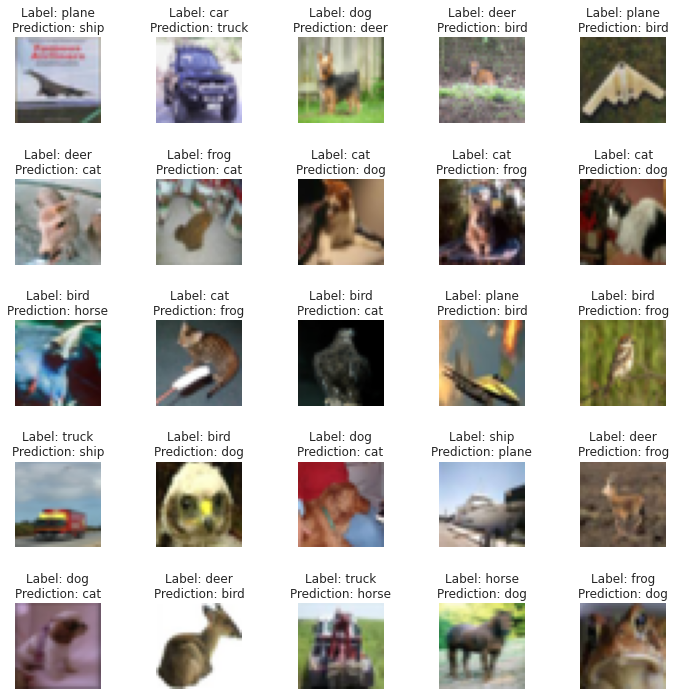

In [14]:
utility.save_and_show_result(incorrect_samples, classes)

## print the summary 

In [17]:
main.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 84 %
Accuracy of   car : 94 %
Accuracy of  bird : 83 %
Accuracy of   cat : 78 %
Accuracy of  deer : 87 %
Accuracy of   dog : 79 %
Accuracy of  frog : 96 %
Accuracy of horse : 84 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %
